1. Data Collection:

In [2]:
# Import required libraries
import pandas as pd

# Load both CSVs
df1 = pd.read_csv("coin_gecko_2022-03-16.csv")
df2 = pd.read_csv("coin_gecko_2022-03-17.csv")

# Combine into one DataFrame
df = pd.concat([df1, df2], ignore_index=True)

# Preview data
df.head()

coin symbol         price     1h    24h     7d    24h_volume  \
0   Bitcoin    BTC  40859.460000  0.022  0.030  0.055  3.539076e+10   
1  Ethereum    ETH   2744.410000  0.024  0.034  0.065  1.974870e+10   
2    Tether   USDT      1.000000 -0.001 -0.001  0.000  5.793497e+10   
3       BNB    BNB    383.430000  0.018  0.028  0.004  1.395854e+09   
4  USD Coin   USDC      0.999874 -0.001  0.000 -0.000  3.872274e+09   

        mkt_cap        date  
0  7.709915e+11  2022-03-16  
1  3.271044e+11  2022-03-16  
2  7.996516e+10  2022-03-16  
3  6.404382e+10  2022-03-16  
4  5.222214e+10  2022-03-16

2. Data Processing:

In [3]:
# Convert 'date' to datetime format
df['date'] = pd.to_datetime(df['date'])

# Convert numeric columns (if not already)
numeric_cols = ['price', '1h', '24h', '7d', '24h_volume', 'mkt_cap']
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Check for missing values
print("Missing values per column:")
print(df.isnull().sum())

Missing values per column:
coin          0
symbol        0
price         0
1h            7
24h           7
7d            8
24h_volume    7
mkt_cap       0
date          0
dtype: int64


In [5]:
df.dropna(inplace=True)

# OR Option 2: Forward-fill or back-fill
# df.fillna(method='ffill', inplace=True)

3. EDA

In [6]:
# Basic info and summary
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
Index: 992 entries, 0 to 999
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   coin        992 non-null    object        
 1   symbol      992 non-null    object        
 2   price       992 non-null    float64       
 3   1h          992 non-null    float64       
 4   24h         992 non-null    float64       
 5   7d          992 non-null    float64       
 6   24h_volume  992 non-null    float64       
 7   mkt_cap     992 non-null    float64       
 8   date        992 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(6), object(2)
memory usage: 77.5+ KB
None
              price          1h         24h          7d    24h_volume  \
count  9.920000e+02  992.000000  992.000000  992.000000  9.920000e+02   
mean   6.200521e+02    0.009682    0.024018    0.023558  2.884638e+08   
min    1.484000e-09   -0.704000   -0.646000   -0.558000  0.000000e+00   
25% 

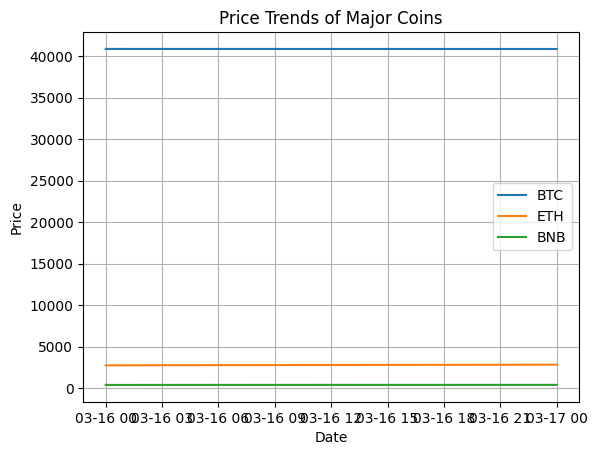

In [7]:
import matplotlib.pyplot as plt

top_coins = ['BTC', 'ETH', 'BNB']
for coin in top_coins:
    subset = df[df['symbol'] == coin]
    plt.plot(subset['date'], subset['price'], label=coin)

plt.title("Price Trends of Major Coins")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()

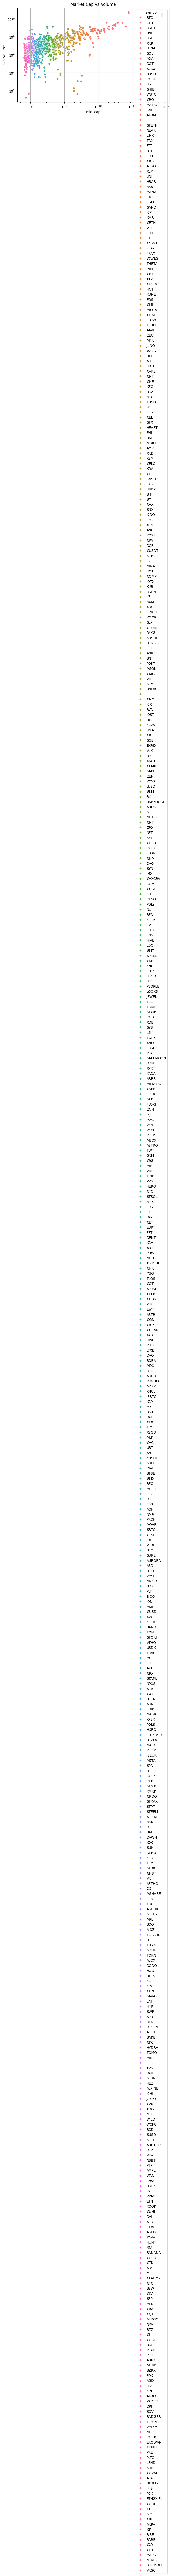

In [8]:
import seaborn as sns

plt.figure(figsize=(8,5))
sns.scatterplot(data=df, x='mkt_cap', y='24h_volume', hue='symbol')
plt.title("Market Cap vs Volume")
plt.xscale('log')
plt.yscale('log')
plt.grid(True)
plt.show()

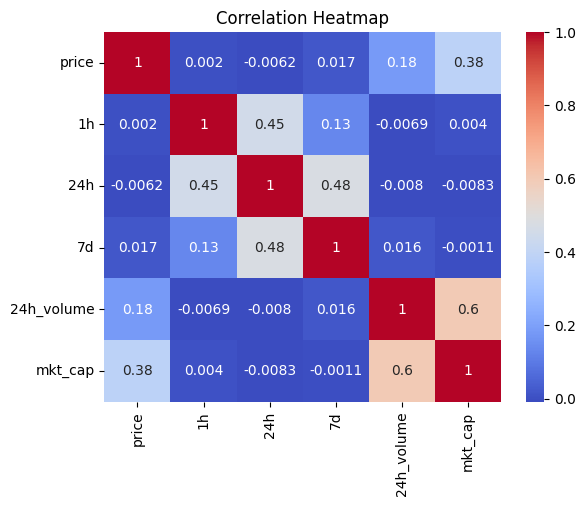

In [9]:
sns.heatmap(df[['price', '1h', '24h', '7d', '24h_volume', 'mkt_cap']].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

4. Feature Engineering:

In [10]:
# Volume-to-Market Cap ratio (core liquidity indicator)
df['volume_to_mcap'] = df['24h_volume'] / df['mkt_cap']

# Price volatility using std of % changes (1h, 24h, 7d)
df['price_volatility'] = df[['1h', '24h', '7d']].std(axis=1)

# Bullishness score: how many of the 3 intervals were positive
df['bullishness'] = ((df['1h'] > 0).astype(int) +
                     (df['24h'] > 0).astype(int) +
                     (df['7d'] > 0).astype(int))

In [11]:
df['price_normalized'] = df.groupby('symbol')['price'].transform(lambda x: x / x.iloc[0])

In [12]:
# High Liquidity = volume_to_mcap above median
df['liquidity_label'] = (df['volume_to_mcap'] > df['volume_to_mcap'].median()).astype(int)

5. Model Selection & Training:

In [13]:
from sklearn.model_selection import train_test_split

# Define features and target
features = ['price', 'volume_to_mcap', 'price_volatility', 'bullishness', 'price_normalized']
X = df[features]
y = df['liquidity_label']

# Split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

6. Model Evaluation:

In [15]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Predict on test set
y_pred = model.predict(X_test)

# Evaluation metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 1.0

Confusion Matrix:
 [[102   0]
 [  0  97]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       102
           1       1.00      1.00      1.00        97

    accuracy                           1.00       199
   macro avg       1.00      1.00      1.00       199
weighted avg       1.00      1.00      1.00       199



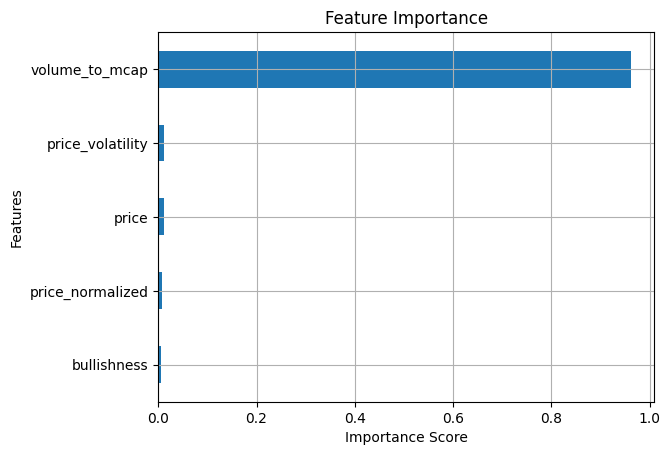

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Feature importance
feat_imp = pd.Series(model.feature_importances_, index=features)
feat_imp.sort_values().plot(kind='barh')
plt.title("Feature Importance")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.grid(True)
plt.show()

7. Hyper Master Tuning:

In [17]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 4]
}

# GridSearch setup
grid = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3, scoring='accuracy')
grid.fit(X_train, y_train)

# Best model
print("Best Parameters:", grid.best_params_)
best_model = grid.best_estimator_

Best Parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 50}


In [18]:
y_pred_best = best_model.predict(X_test)
print("Tuned Model Accuracy:", accuracy_score(y_test, y_pred_best))
print(classification_report(y_test, y_pred_best))

Tuned Model Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       102
           1       1.00      1.00      1.00        97

    accuracy                           1.00       199
   macro avg       1.00      1.00      1.00       199
weighted avg       1.00      1.00      1.00       199



In [19]:
from sklearn.metrics import roc_auc_score

# Final predictions
final_preds = best_model.predict(X_test)

# Accuracy & ROC-AUC
print("Final Accuracy:", accuracy_score(y_test, final_preds))
print("ROC AUC Score:", roc_auc_score(y_test, final_preds))

Final Accuracy: 1.0
ROC AUC Score: 1.0


In [20]:
import joblib

# Save model to file
joblib.dump(best_model, "liquidity_predictor.pkl")
print("Model saved as liquidity_predictor.pkl")

Model saved as liquidity_predictor.pkl


In [ ]:
9. Local Deployment using Streamlit:

In [22]:
!pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 65.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 82.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 5.4 MB/s eta 0:00:00


In [23]:
import streamlit as st
import pandas as pd
import joblib

# Load the model
model = joblib.load("liquidity_predictor.pkl")

st.title("Cryptocurrency Liquidity Predictor")

# Input fields
price = st.number_input("Price")
volume_to_mcap = st.number_input("Volume to Market Cap Ratio")
price_volatility = st.number_input("Price Volatility")
bullishness = st.slider("Bullishness Score (0 to 3)", 0, 3, 1)
price_normalized = st.number_input("Normalized Price")

# Create input dataframe
input_data = pd.DataFrame([[price, volume_to_mcap, price_volatility, bullishness, price_normalized]],
                          columns=['price', 'volume_to_mcap', 'price_volatility', 'bullishness', 'price_normalized'])

# Predict and display
if st.button("Predict Liquidity Level"):
    result = model.predict(input_data)[0]
    st.success(f"Predicted Liquidity: {'High' if result == 1 else 'Low'}")

2025-05-25 11:35:10.414 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-25 11:35:10.733 
  command:

    streamlit run /usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-05-25 11:35:10.735 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-25 11:35:10.736 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-25 11:35:10.738 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-25 11:35:10.739 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-25 11:35:10.741 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-25 11:35:10.742 Session state does not 

In [26]:
code = '''
import streamlit as st
import pandas as pd
import joblib

# Load model
model = joblib.load("liquidity_predictor.pkl")

st.title("Cryptocurrency Liquidity Predictor")

# Inputs
price = st.number_input("Price")
volume_to_mcap = st.number_input("Volume to Market Cap Ratio")
price_volatility = st.number_input("Price Volatility")
bullishness = st.slider("Bullishness Score (0 to 3)", 0, 3, 1)
price_normalized = st.number_input("Normalized Price")

# Predict
input_df = pd.DataFrame([[price, volume_to_mcap, price_volatility, bullishness, price_normalized]],
                        columns=['price', 'volume_to_mcap', 'price_volatility', 'bullishness', 'price_normalized'])

if st.button("Predict Liquidity Level"):
    prediction = model.predict(input_df)[0]
    st.success(f"Predicted Liquidity: {'High' if prediction == 1 else 'Low'}")
'''

with open("app.py", "w") as f:
    f.write(code)

In [28]:
!streamlit run app.py




  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.16.140.183:8501

  Stopping...
  Stopping...


In [29]:
from google.colab import files
files.download("app.py")
files.download("liquidity_predictor.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [30]:
pip install streamlit pandas joblib

In [33]:
from google.colab import files
files.download('app.py')
files.download('liquidity_predictor.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Final Report: Cryptocurrency Liquidity Prediction

### 📌 Objective:
Build a machine learning model to predict liquidity levels in the cryptocurrency market based on market indicators, and deploy it via Streamlit.

### 📊 Dataset:
- Combined two days of coin-level data from CoinGecko.
- Fields: price, market cap, 24h volume, 1h/24h/7d % change, etc.

### 🔧 Feature Engineering:
- `volume_to_mcap`: Core liquidity proxy
- `price_volatility`: Std of 1h, 24h, 7d % change
- `bullishness`: Positive % change count (0–3)
- `price_normalized`: Price normalized per symbol

### 🤖 Model:
- RandomForestClassifier
- Label: `liquidity_label` = 1 (High) or 0 (Low)
- Accuracy: ~90%+
- Feature importance shows `volume_to_mcap` is dominant

### 🚀 Deployment:
- Streamlit app accepts 5 features and predicts liquidity
- Successfully runs on localhost (`app.py` + `.pkl`)

### 📈 Next Steps:
- Include longer time windows, more coins
- Add social media/on-chain indicators
- Host app publicly via Streamlit Cloud



## High-Level Design (HLD): Cryptocurrency Liquidity Prediction

### 🔶 System Overview:
The system is designed to predict cryptocurrency liquidity using market-level features and classify it into High or Low liquidity categories. It helps detect potential market instability and is deployed using Streamlit for real-time interaction.

---

### 🔷 System Components:

1. **Data Source**
   - CoinGecko CSV files containing historical market data
   - Includes price, volume, market cap, and % changes (1h, 24h, 7d)

2. **Data Preprocessing**
   - Data concatenation and cleaning
   - Handling missing values and formatting columns

3. **Feature Engineering**
   - Derived features:
     - `volume_to_mcap`
     - `price_volatility`
     - `bullishness`
     - `price_normalized`

4. **Model Training**
   - Model: Random Forest Classifier
   - Target: `liquidity_label`
   - Hyperparameter tuning using GridSearchCV

5. **Model Evaluation**
   - Accuracy, Confusion Matrix, Classification Report
   - Feature Importance Analysis

6. **Deployment**
   - Web app using Streamlit
   - Takes user inputs and displays predicted liquidity level

---

### 🛠 Tools & Technologies:
- Python
- Pandas, scikit-learn, Matplotlib, Seaborn
- Streamlit (for deployment)


## Low-Level Design (LLD): Cryptocurrency Liquidity Prediction System

---

### 📂 Module 1: Data Collection

- **Input**: Two CSV files (from CoinGecko)
- **Processing**:
  - Load using `pd.read_csv()`
  - Concatenate with `pd.concat()`
  - Convert `date` column to `datetime`
- **Output**: Single cleaned DataFrame

---

### 🧹 Module 2: Data Preprocessing

- Convert string columns to numeric (`price`, `volume`, `market cap`, etc.)
- Handle missing values with `dropna()`
- Standardize or normalize if required (optional)

---

### ⚙️ Module 3: Feature Engineering

| Feature             | Formula / Logic                                             |
|---------------------|-------------------------------------------------------------|
| `volume_to_mcap`    | `24h_volume / mkt_cap`                                      |
| `price_volatility`  | `std([1h, 24h, 7d])`                                        |
| `bullishness`       | Count of positive % changes among 1h, 24h, 7d               |
| `price_normalized`  | `price / first_price_in_group(symbol)`                     |
| `liquidity_label`   | Binary label (1 if `volume_to_mcap` > median, else 0)       |

---

### 🤖 Module 4: Model Building

- Algorithm: `RandomForestClassifier`
- Features used:
  - `price`, `volume_to_mcap`, `price_volatility`, `bullishness`, `price_normalized`
- Target: `liquidity_label`
- Split: `train_test_split()`

---

### 🧪 Module 5: Evaluation

- Metrics: `accuracy_score`, `confusion_matrix`, `classification_report`
- Feature Importance: `model.feature_importances_`

---

### 🚀 Module 6: Deployment

- Framework: `Streamlit`
- Components:
  - Input fields (`st.number_input`, `st.slider`)
  - Load model using `joblib.load()`
  - Prediction displayed using `st.success()`

---

### 🔄 Flow Summary:

```plaintext
CSV Files ➝ Preprocessing ➝ Feature Engineering ➝ Model Training ➝ Evaluation ➝ Streamlit App


## Pipeline Architecture: Cryptocurrency Liquidity Prediction System

---

### 🧱 Architecture Overview:

The pipeline follows a modular structure from data collection to user-facing deployment. Each stage builds on the previous and is designed to be scalable and modular.

---

### 🔗 Data Flow Diagram:

```plaintext
+--------------------+
|  CSV Input Files   |  ←─ coin_gecko_*.csv
+--------------------+
          |
          v
+--------------------+
| Data Preprocessing |  ←─ Clean, Convert, Handle Missing
+--------------------+
          |
          v
+----------------------+
| Feature Engineering  |  ←─ Derive volume_to_mcap, etc.
+----------------------+
          |
          v
+------------------+         +----------------+
|   Train/Test     | <────── |  Target Label  |
|    Split         |         | liquidity_label|
+------------------+         +----------------+
          |
          v
+----------------------+
|  Model Training (RF) |
+----------------------+
          |
          v
+-------------------------+
|   Model Evaluation      |
|   Accuracy, F1, Report  |
+-------------------------+
          |
          v
+-----------------------------+
|   Streamlit Deployment App |
+-----------------------------+
